<a href="https://colab.research.google.com/github/Anu-vibes/text-emotion-analysis/blob/main/CNN_LSTM_dataset1_ANU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM,GRU, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Defining vector space dimension and fixed input size

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words)
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing our training and testing datasets

In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('/content/drive/MyDrive/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text
y_train = data_train.Emotion
y_test = data_test.Emotion

data = pd.concat([data_train, data_test], ignore_index=True)

In [ ]:
print(data.Emotion.value_counts())
data.head(6)

Emotion
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: count, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


data cleaning

In [ ]:
def clean_text(data):

    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)

    # tekenization using nltk
    data = word_tokenize(data)

    return data

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
print(texts_train[92])

a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12087


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10258,   173,    13]], dtype=int32)

In [ ]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

3. Import pretrained word vectors

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12088, 300)

In [ ]:

# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 645


In [ ]:
# Embedding layer before the actaul LSTM
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Parameters
lstm_output_size = 128
bidirectional = True

# Define the model
model = Sequential()

# Add the embedding layer
model.add(embedd_layer)

# Add the Convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Add LSTM or biLSTM layer
if bidirectional:
    model.add(Bidirectional(LSTM(units=lstm_output_size,
                                  dropout=0.2,
                                  recurrent_dropout=0.2)))
else:
    model.add(LSTM(units=lstm_output_size,
                   dropout=0.2,
                   recurrent_dropout=0.2))

# Add Dense layer and output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626400   
                                                                 
 conv1d (Conv1D)             (None, 500, 64)           57664     
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 64)           0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 256)               197632    
 al)                                                             
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 3882981 (14.81 MB)
Trainable params: 25658

5. Train the Model

In [ ]:
batch_size = 128
epochs = 10

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/10
62/62 [==============================] - 345s 6s/step - loss: 1.2407 - accuracy: 0.4956 - val_loss: 1.0171 - val_accuracy: 0.6263
Epoch 2/10
62/62 [==============================] - 348s 6s/step - loss: 0.9152 - accuracy: 0.6615 - val_loss: 0.8678 - val_accuracy: 0.6758
Epoch 3/10
62/62 [==============================] - 329s 5s/step - loss: 0.7881 - accuracy: 0.7106 - val_loss: 0.8117 - val_accuracy: 0.7029
Epoch 4/10
62/62 [==============================] - 350s 6s/step - loss: 0.7149 - accuracy: 0.7387 - val_loss: 0.8096 - val_accuracy: 0.7035
Epoch 5/10
62/62 [==============================] - 356s 6s/step - loss: 0.6749 - accuracy: 0.7614 - val_loss: 0.7954 - val_accuracy: 0.7047
Epoch 6/10
62/62 [==============================] - 333s 5s/step - loss: 0.6300 - accuracy: 0.7783 - val_loss: 0.7920 - val_accuracy: 0.7171
Epoch 7/10
62/62 [==============================] - 364s 6s/step - loss: 0.5953 - accuracy: 0.7896 - val_loss: 0.7737 - val_accuracy: 0.7241
Epoch 8/10
62

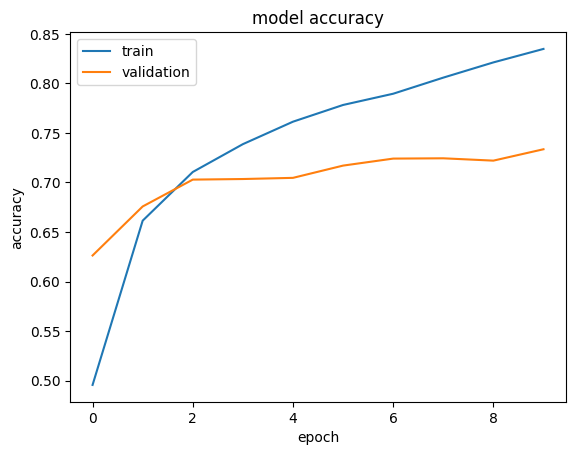

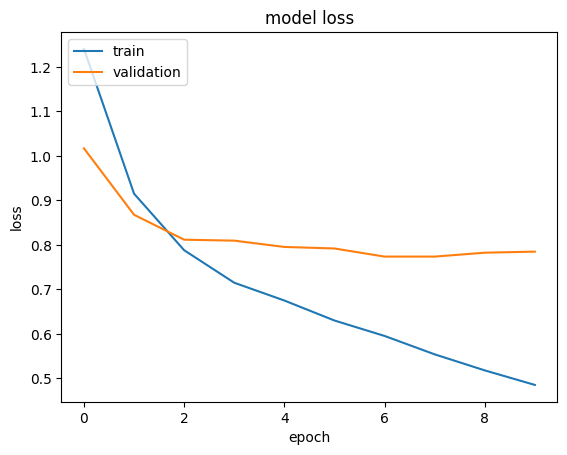

In [ ]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

6. Evaluation

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

from sklearn.metrics import precision_score, recall_score
precision = precision_score(data_test.Emotion, predictions, average='micro')
recall = recall_score(data_test.Emotion, predictions, average='micro')
print("Precision: {:.2f}".format(precision * 100))
print("Recall: {:.2f}".format(recall * 100))


107/107 [==============================] - 31s 283ms/step
Accuracy: 73.36%

F1 Score: 73.36
Precision: 73.36
Recall: 73.36


In [ ]:
#plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 73.36


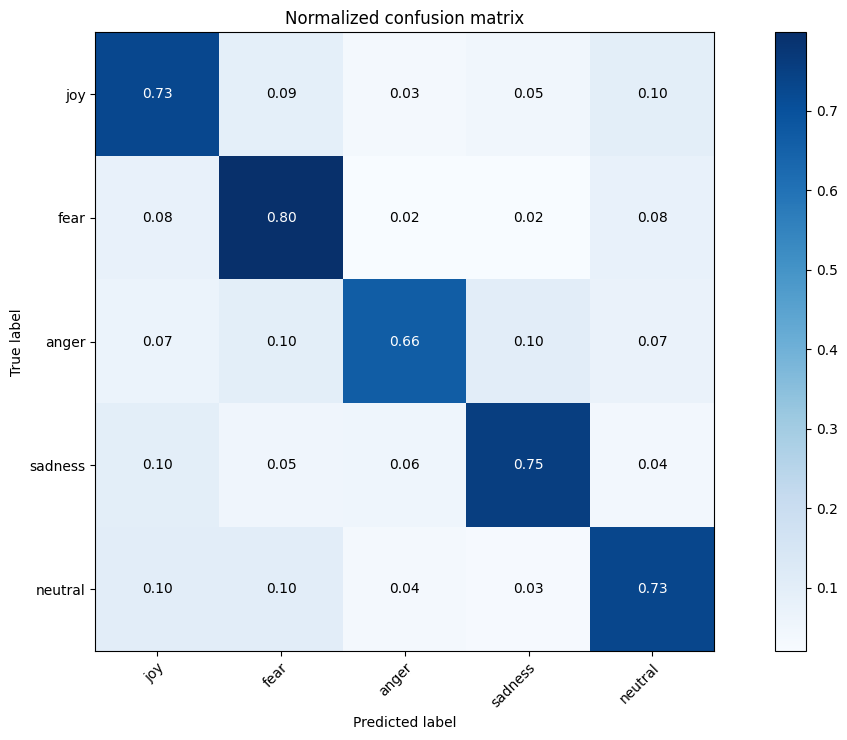

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Try other input

In [ ]:
# creates a HDF5 file 'my_model.h5'
model.save('CNN-LSTM-dataset1-ANU.h5')

In [ ]:
from keras.models import load_model
predictor = load_model('/content/drive/MyDrive/CNN-LSTM-dataset1-ANU.h5')

In [ ]:
import time

message = ['When I meet you first time it was wonderful']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = predictor.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 3s 3s/step
Message: ['When I meet you first time it was wonderful']
predicted: joy (3.15 seconds)
